# Objectives: A classification data set with skewed class proportions is called imbalanced. Classes that make up a large proportion of the data set are called majority classes. Those that make up a smaller proportion are minority classes.An effective way to handle imbalanced data is to downsample and upweight the majority class. Let's start by defining those two new terms:

Downsampling (in this context) means training on a disproportionately low subset of the majority class examples.
Upweighting means adding an example weight to the downsampled class equal to the factor by which you downsampled.
-
-

### Getting Started:
- Colab notebooks consist of text cells (like this one) and program code cells, like the one shown below. Code cells are executed by typing the Cmd+Enter keys (or Ctrl-Enter). You can also execute a code cell by mousing over the [ ] symbol in the upper left hand side of the code cell---when you hover over it it will turn into a "play" button, and clicking the play button will execute the code cell. You can find other options for executing groups of cells in the "Runtime" menu above.

- Start by executing the code cell below (the one that begins with the line import pandas as pd). This loads ("imports") the required software modules that will be used in the assignment.
## Loading Python Libraries

In [1]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,KBinsDiscretizer,OneHotEncoder,StandardScaler
 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.metrics import confusion_matrix,recall_score
from sklearn.compose import ColumnTransformer
 
from scipy import stats
 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Take a moment to look at this code block:
- import loads a module
- import ... as allows you to assign a short alias to the module
- from ... import loads a small portion of a module
- observe that the import, as and from keywords are color coded purple.
indicates a comment (observe that all of the text following the # is color coded green). This text is not interpreted by the computer, and its goal is to provide the human with some information about what is happening.<BR><BR>
What do each of these program modules do? You can think of them as being like a library of books that accomplish program tasks. In general, they can be quite complicated. In most cases, you will never learn all of the functionality of a module, and will have to use the documentation to help you determine the relevant parts for solving your problem. It is useful to have a general sense of the types of tasks that each of modules do, so that you can find the appropriate functionality.

- `pandas` is a library for handling datasets
- `numpy` and `scipy` are libraries for mathematical and scientific computing
- `matplotlib` and `plotly` are libraries for data visualization
- `sklearn` and `imblearn` are libraries for machine learning

Importing file:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ORGANIC.xlsx to ORGANIC.xlsx


In [3]:
import io
df = pd.read_excel(io.BytesIO(uploaded['ORGANIC.xlsx']))
df.head()

,shelf,book,page,λ,n,k
0,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.196,0.6096
1,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.209,0.6501
2,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.228,0.7096
3,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.235,0.7315
4,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.1012,1.417,0.4472


In [4]:
# Creating a copy so that our original remain intact.
new_df = df.copy()

## Exploring the dataset

In [5]:
df.shape

(252130, 6)

In [6]:
# Investigating all the elements within each feature
for column in df:
    unique_vals = np.unique(df[column].astype(str))
    nr_values = len(unique_vals)
    
    if nr_values < 36:
        print('The number of values for feature -  {} : {} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} : {}'.format(column, nr_values))

The number of values for feature -  shelf : 1 -- ['organic']
The number of values for feature book : 61
The number of values for feature page : 59
The number of values for feature λ : 54358
The number of values for feature n : 41463
The number of values for feature k : 195870


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252130 entries, 0 to 252129
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   shelf   252130 non-null  object 
 1   book    252130 non-null  object 
 2   page    252129 non-null  object 
 3   λ       252129 non-null  float64
 4   n       245286 non-null  float64
 5   k       242239 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.5+ MB


In [8]:
#filling missing values in k with '0'
df['k'].fillna(0,inplace=True)
# Dropping all the null values from n
df.dropna(axis=0,inplace=True)   

We don't require 'Shelf' and 'Page' for the training and texting purpose.
Dropping "Shelf" and "Page"

In [9]:
df.drop(['shelf','page'],axis=1,inplace=True)

In [10]:
df.shape

(245286, 4)

We are down from 252130 rows to 245286, and from 6 columns to 4.<br>
We also need to catagories Wavelength into "UV", "visible_light", "near_IR", "IR_rays" and "Far_IR_Rays", based on the range mentioned below.

In [11]:
# Creating a new Column for the wavelength catagory:
df['λ_binned'] = pd.cut(df['λ'], [-np.inf,0.4,0.75,1.5,4.0,np.inf],
                            labels=['UV','visible_light','near_IR','IR_rays','Far_IR_Rays'])
df.head()

,book,λ,n,k,λ_binned
0,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.196,0.6096,UV
1,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.209,0.6501,UV
2,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.228,0.7096,UV
3,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.235,0.7315,UV
4,(C2ClF3)n - polychlorotrifluoroethylene,0.1012,1.417,0.4472,UV


In [12]:
# Distribution of datapoints amongst different wavelengths
df.λ_binned.value_counts()

IR_rays          135408
Far_IR_Rays       66678
near_IR           35446
visible_light      5980
UV                 1774
Name: λ_binned, dtype: int64

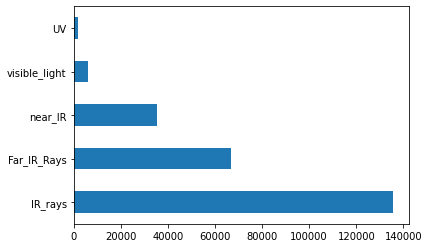

In [13]:
df.λ_binned.value_counts().plot(kind='barh')
plt.show()

### There is very high class imbalance - We can see that uv and visible light are having very few samples, compared to the next three.

- Dividing the dataframe into two parts : `df_minor` and `df_major`.
-`df_minor` will have "UV" and "Visible Light".
- `df_major` will have "near_IR", "IR_rays" and "Far_IR_Rays". 

In [25]:
df.shape

(245286, 5)

In [26]:
# Creating df_minor and df_major based on the wavelength category mensioned above
df_minor = df[ (df.λ_binned=='UV') | (df.λ_binned=='visible_light')]
df_major = df[df.λ_binned!='UV']
df_major = df_major[df.λ_binned!='visible_light']
df_major.λ_binned.unique()
print('Length of df_minor : {}\nLength of df_major : {} '.format(len(df_minor), len(df_major)))

Length of df_minor : 7754
Length of df_major : 237532 


- Downsampling `majority class` i.e. `df_major`
- Upsampling `minority class`, i.e. `df_minor`
- Combining the above two in `df_up_down_sampled`

In [27]:
from sklearn.utils import resample
#Downsample majority class
df_majority_downsampled = resample(df_major, 
                                 replace=False,    
                                 n_samples=150000,
                                 stratify = df_major['λ_binned'],
                                 random_state=42)
#Upsample minority class
df_minority_upsampled = resample(df_minor, 
                                 replace=True,     
                                 n_samples=60000,
                                 stratify = df_minor['λ_binned'],
                                 random_state=42)
# Combine minority class with df_majority_downsampled class
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled],ignore_index=True)

In [28]:
# Final shape of the combined dataframe
print("Size of the new combined dataframe 'df_up_down_sampled' : ", end= "")
print(df_up_down_sampled.shape[0])

Size of the new combined dataframe 'df_up_down_sampled' : 210000


In [29]:
# Distribution of datapoint amongst different Wavelength categories.
df_up_down_sampled.λ_binned.value_counts()

IR_rays          85509
visible_light    46273
Far_IR_Rays      42107
near_IR          22384
UV               13727
Name: λ_binned, dtype: int64

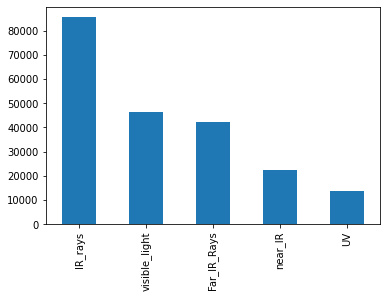

In [30]:
df_up_down_sampled.λ_binned.value_counts().plot(kind='bar')
plt.show()

In [31]:
df_up_down_sampled.head()

,book,λ,n,k,λ_binned
0,nitrobenzene,2.17319,1.52008,0.000180,IR_rays
1,dichloromethane,3.95990,1.41050,0.000301,IR_rays
2,Methanol,3.54851,1.38379,0.045790,IR_rays
3,octane,2.60810,1.39480,0.000110,IR_rays
4,nitrobenzene,10.65300,1.51348,0.020930,Far_IR_Rays


## Splitting the modified Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

In [32]:
df_up_down_sampled.drop('λ',axis=1,inplace=True)
y = df_up_down_sampled['book']               # Target Vector
x = df_up_down_sampled.drop('book',axis=1)   # Input Features (attributes)

print('x shape: {}'.format(np.shape(x)[0]))
print('y shape: {}'.format(np.shape(y)[0]))

x shape: 210000
y shape: 210000


*`75%` data is for training and `25%` data is for testing.*

In [33]:
#split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42,stratify=x.λ_binned)

In [34]:
print('Length of x_test : {}\nLength of y_test : {}\nLength of x_train : {}\nLength of y_train : {}'.format(len(x_test),  len(y_test), len(x_train), len(y_train)))

Length of x_test : 52500
Length of y_test : 52500
Length of x_train : 157500
Length of y_train : 157500


`λ_binned` is our Catagorical features, whereas, `n` and `k` are Numerical features.

In [35]:
cat_features = ['λ_binned']
numeric_features = ['n','k']

In [36]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])

categorical_transformer = Pipeline(steps=[
                                          ('onehot',OneHotEncoder())
                                          ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ('category',categorical_transformer,cat_features)
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classifier',RandomForestClassifier(random_state=42))
           ])

## Model

In [38]:
# model
rf_model = pipeline.fit(x_train, y_train)
print (rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['n', 'k']),
                                                 ('category',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['λ_binned'])])),
                ('classifier', RandomForestClassifier(random_state=42))])


In [39]:
# Training and testing Accuracy
print(f'Training accuracy {rf_model.score(x_train,y_train)}')
print(f'Test accuracy {rf_model.score(x_test,y_test)}')

Training accuracy 0.978031746031746
Test accuracy 0.8706285714285714


In [40]:
UV = x_test[x_test.λ_binned== 'UV']
UV_y = y_test[x_test.λ_binned== 'UV']
Visible = x_test[x_test.λ_binned== "Visible"]
Visible_y = y_test[x_test.λ_binned == "Visible"]
Near_IR = x_test[x_test.λ_binned== 'Near_IR']
Near_IR_y = y_test[x_test.λ_binned== 'Near_IR']
IR = x_test[x_test.λ_binned== 'IR']
IR_y = y_test[x_test.λ_binned== 'IR']
Far_IR = x_test[x_test.λ_binned== 'Far_IR']
Far_IR_y = y_test[x_test.λ_binned== 'Far_IR']

### Precision, Recall, F1-Score of this model

In [41]:
y_pred = rf_model.predict(x_test)
print(len(y_pred), len(x_test))

52500 52500


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                         precision    recall  f1-score   support

(C2ClF3)n - polychlorotrifluoroethylene       0.38      0.44      0.41        54
           (C6H12)n - polymethylpentene       0.00      0.00      0.00         7
                              Acetylene       1.00      1.00      1.00       200
                            Cyclohexane       1.00      1.00      1.00       907
                          Ethyl acetate       1.00      0.99      0.99       167
                               Ethylene       1.00      1.00      1.00       219
                                Heptane       1.00      1.00      1.00       617
                                 Hexane       1.00      1.00      1.00       762
                               Methanol       0.88      0.90      0.89      2870
                 Pentanol, amyl alcohol       0.98      0.98      0.98       144
                            acetic_acid       0.99      0.97      0.98       156
                           

#### Checking the accuracy catagory wise, for: `UV`, `Far_IR_Rays`, `IR_rays`, `near_IR`,`visible_light` , individually

### For Training Set :

In [43]:
# Here are the accuracies in the tabular format:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
tr_scores = []

for l in labls:
  train_x = x_train[x_train.λ_binned==l]
  train_y = y_train[x_train.λ_binned==l]
 
  tr_scores.append(rf_model.score(train_x,train_y))
for i in range(len(labls)):
    print(labls[i],":", tr_scores[i])

UV : 0.9870811073336572
Far_IR_Rays : 0.9981950601646612
IR_rays : 0.949120563837086
near_IR : 0.9999404336430784
visible_light : 0.9998271142486673


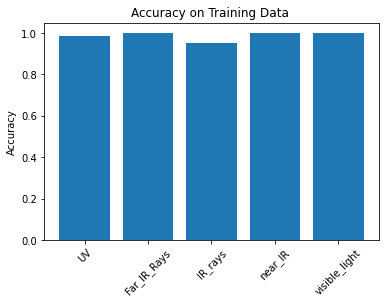

In [44]:
# Accuracy based on different wavelengths
plt.bar(labls,tr_scores)
plt.title('Accuracy on Training Data ')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

### For Test Set :

In [45]:
# Here are the accuracies in the tabular format:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
ts_scores = []

for l in labls:
  test_x = x_test[x_test.λ_binned==l]
  test_y = y_test[x_test.λ_binned==l]
 
  ts_scores.append(rf_model.score(test_x,test_y))
for i in range(len(labls)):
    print(labls[i],":", ts_scores[i])

UV : 0.9784382284382285
Far_IR_Rays : 0.7014344067635604
IR_rays : 0.8392665013799878
near_IR : 0.979807005003574
visible_light : 0.9977524204702628


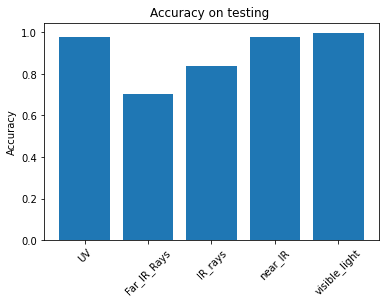

In [46]:
# Accuracy based on different wavelengths
plt.bar(labls,ts_scores)
plt.title('Accuracy on testing ')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

### Prediction on up-down sampled data

## Splitting the Raw Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

### Prediction Time:

In [47]:
pred = rf_model.predict(x_test)

In [48]:
# Predicting the Book, based on the the parameters:
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('UV',1,0,rf_model)

'Book is methane'

### Confusion Matrix

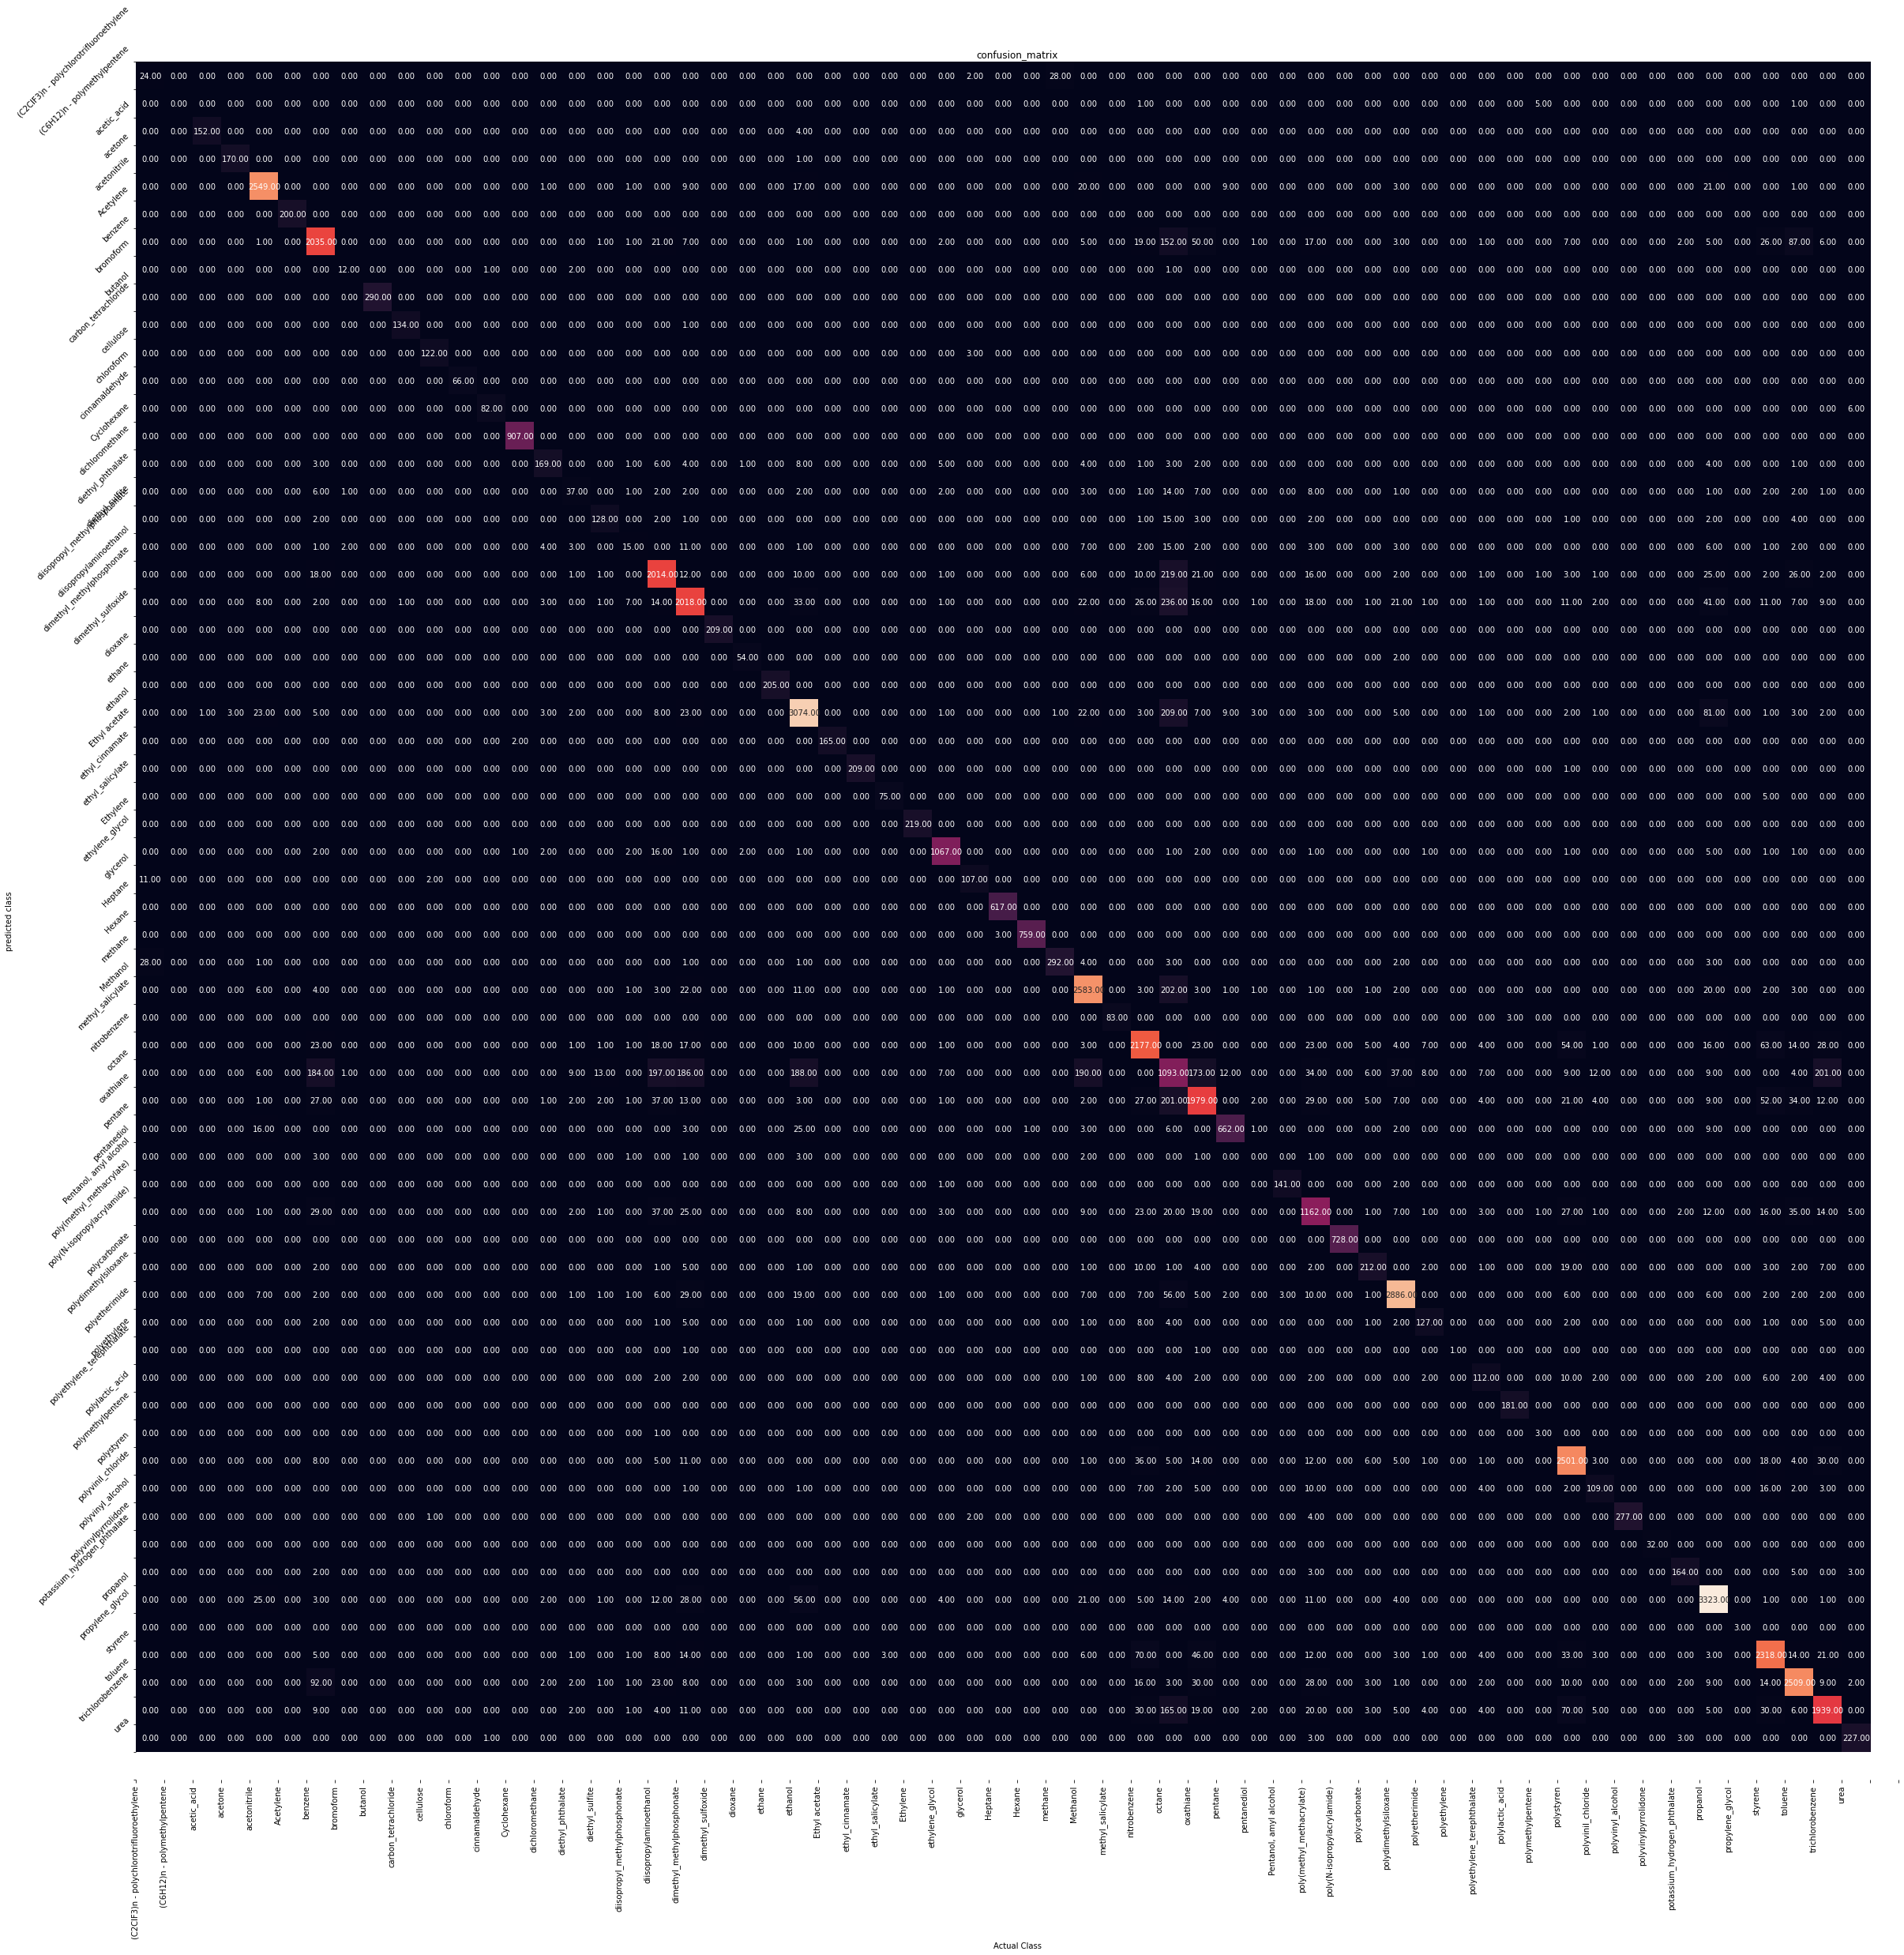

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
cm = confusion_matrix(y_test,pred,labels=list(df.book.unique()))
sns.heatmap(cm,annot=True,fmt='.2f',cbar=False)
plt.xticks(range(0,63),labels=list(df.book.unique()),rotation=90)
plt.yticks(range(0,63),labels=list(df.book.unique()),rotation=45)
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

### Checking the accuracy on bases of the Wavelength Catagory:

In [50]:
# Creating test set based upon the category of Wavelength they belong to:
UV = x_test[x_test.λ_binned=='UV']
UV_y = y_test[x_test.λ_binned=='UV']
Near_IR = x_test[x_test.λ_binned=='near_IR']
Near_IR_y = y_test[x_test.λ_binned=='near_IR']
Far_IR = x_test[x_test.λ_binned=='Far_IR_Rays']
Far_IR_y = y_test[x_test.λ_binned=='Far_IR_Rays']
IR = x_test[x_test.λ_binned=='IR_rays']
IR_y = y_test[x_test.λ_binned=='IR_rays']
Visible = x_test[x_test.λ_binned=='visible_light']
Visible_y = y_test[x_test.λ_binned=='visible_light']

In [51]:
# Prediction 1: 
print(UV[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',UV_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(UV[10:19]))

               n         k λ_binned
156636  1.385248  0.000000       UV
188463  1.459180  0.000000       UV
183269  1.515344  0.000000       UV
158822  1.459930  0.000000       UV
186920  1.434280  0.000014       UV
155216  1.414910  0.000001       UV
151948  1.491000  0.568100       UV
170486  1.420000  0.455100       UV
162354  1.493600  0.000001       UV
------------------------------------------------------------------------------------------

Actual Class

 156636                 Heptane
188463    polydimethylsiloxane
183269      dimethyl_sulfoxide
158822    polydimethylsiloxane
186920                 ethanol
155216    polydimethylsiloxane
151948                 methane
170486                 methane
162354         ethylene_glycol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['Heptane' 'polydimethylsiloxane' 'dimethyl_sulfoxide'
 'polydimethylsiloxane' 'ethanol' 'polydimethylsiloxane' 'metha

We can see that the prediction matched the actual class perfectly. 
### Some more predictions :

In [52]:
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('UV',1.437401e+00,0.000000e+00,rf_model)

'Book is polydimethylsiloxane'

In [53]:
# Prediction 2:
print(Near_IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Near_IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Near_IR[10:19]))

              n         k λ_binned
144248  1.36225  0.000022  near_IR
18911   1.48890  0.000002  near_IR
83877   1.31264  0.000033  near_IR
119300  1.47454  0.000015  near_IR
5615    1.48885  0.000009  near_IR
145959  1.55373  0.000056  near_IR
66591   1.48876  0.000006  near_IR
66441   1.39629  0.000002  near_IR
58572   1.34809  0.000045  near_IR
------------------------------------------------------------------------------------------

Actual Class

 144248                propanol
18911                oxathiane
83877                 Methanol
119300                 toluene
5615                 oxathiane
145959              polystyren
66591                oxathiane
66441     polydimethylsiloxane
58572                  ethanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['propanol' 'oxathiane' 'Methanol' 'toluene' 'oxathiane' 'polystyren'
 'oxathiane' 'polydimethylsiloxane' 'ethanol']


In [54]:
# near_IR, Prediction
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('near_IR',1.462147,0.000000,rf_model)

'Book is cellulose'

In [55]:
# Prediction 3: Far_IR
print(Far_IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Far_IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Far_IR[10:19]))

              n         k     λ_binned
148832  1.37357  0.003325  Far_IR_Rays
6099    1.51515  0.000133  Far_IR_Rays
40371   1.33391  0.044694  Far_IR_Rays
101443  1.40890  0.000041  Far_IR_Rays
101986  1.45838  0.002715  Far_IR_Rays
119371  1.47481  0.000174  Far_IR_Rays
69866   1.51849  0.012611  Far_IR_Rays
117532  1.48608  0.000430  Far_IR_Rays
116535  1.53698  0.000371  Far_IR_Rays
------------------------------------------------------------------------------------------

Actual Class

 148832    dimethyl_methylphosphonate
6099                         styrene
40371     dimethyl_methylphosphonate
101443               dichloromethane
101986       diisopropylaminoethanol
119371                       toluene
69866                     polystyren
117532                     oxathiane
116535              trichlorobenzene
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['dimethyl_methylphosphonate' 'sty

In [56]:
# Prediction Far_IR_Rays
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('Far_IR_Rays',1.55675,0.003872,rf_model)

'Book is polystyren'

In [57]:
# Prediction 4 : IR
print(IR[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',IR_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(IR[10:19]))

              n         k λ_binned
82464   1.54737  0.000002  IR_rays
1198    1.39937  0.000104  IR_rays
120364  1.39959  0.000043  IR_rays
457     1.47825  0.000343  IR_rays
115559  1.54687  0.000061  IR_rays
127263  1.36903  0.070742  IR_rays
10730   1.36255  0.008164  IR_rays
116756  1.35732  0.000178  IR_rays
105484  1.30221  0.000536  IR_rays
------------------------------------------------------------------------------------------

Actual Class

 82464               trichlorobenzene
1198            polydimethylsiloxane
120364    dimethyl_methylphosphonate
457                          toluene
115559              trichlorobenzene
127263                      Methanol
10730                       Methanol
116756                      propanol
105484                      Methanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['trichlorobenzene' 'octane' 'dimethyl_methylphosphonate' 'toluene'
 'tric

In [58]:
# Prediction, based on the parameters 
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('IR_rays',1.47427,0.000013,rf_model)

'Book is toluene'

In [59]:
# Prediction 5 : Visible rays
print(Visible[10:19])
print('-'*90,end='\n\n')
print('Actual Class\n\n',Visible_y[10:19])
print('-'*90,end='\n\n')
print('Predicted class\n\n',rf_model.predict(Visible[10:19]))

               n             k       λ_binned
177678  1.407150  9.320000e-07  visible_light
198825  1.409740  0.000000e+00  visible_light
167513  1.484673  0.000000e+00  visible_light
158779  1.576300  1.350000e-06  visible_light
161358  1.492778  0.000000e+00  visible_light
153995  1.343125  0.000000e+00  visible_light
204281  1.482300  2.480000e-07  visible_light
175230  1.357770  1.124520e-07  visible_light
179135  1.340532  0.000000e+00  visible_light
------------------------------------------------------------------------------------------

Actual Class

 177678            polydimethylsiloxane
198825            polydimethylsiloxane
167513       poly(methyl_methacrylate)
158779      polyethylene_terephthalate
161358    potassium_hydrogen_phthalate
153995                         pentane
204281       poly(methyl_methacrylate)
175230                         ethanol
179135                    acetonitrile
Name: book, dtype: object
--------------------------------------------------------

In [60]:
# Predictions based on the parameters.
def predict(l_binned,n,k,model):
  pred_df = pd.DataFrame({'λ_binned':[l_binned],
                         'n':[n],
                         'k':[k]})
  pred = model.predict(pred_df)
  return f'Book is {pred[0]}'

predict('visible_light',1.360901, 0.000000e+00,rf_model)

'Book is ethanol'

ROUND-OFF

In [61]:
df.head()

,book,λ,n,k,λ_binned
0,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.196,0.6096,UV
1,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.209,0.6501,UV
2,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.228,0.7096,UV
3,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.235,0.7315,UV
4,(C2ClF3)n - polychlorotrifluoroethylene,0.1012,1.417,0.4472,UV


In [63]:
new_df = df.copy()
new_df.drop('λ_binned',axis=1,inplace=True)

In [64]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])


preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [65]:
#split the data for training and testing

acc_tr = []
acc_ts = []

recall = []

round_place = [1,2,3,4,5]

for r in round_place:
  y = new_df['book']
  x = new_df.drop('book',axis=1).round(r)   #rounding off
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)
  rf_model = pipeline.fit(x_train,y_train)
  acc_tr.append(rf_model.score(x_train,y_train))
  acc_ts.append(rf_model.score(x_test,y_test))

  pred = rf_model.predict(x_test)

  recall.append(recall_score(y_test,pred,average='weighted'))

In [66]:
acc_tr,acc_ts,recall

([0.24957056815463896,
  0.6157346002478746,
  0.7941553782261747,
  0.9058022221739036,
  0.9484464351720989],
 [0.25175304132285314,
  0.6058184664557581,
  0.7411532565800202,
  0.7829327158279247,
  0.7741919702553732],
 [0.25175304132285314,
  0.6058184664557581,
  0.7411532565800202,
  0.7829327158279247,
  0.7741919702553732])

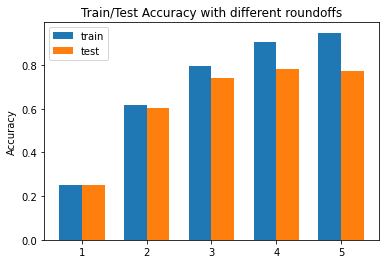

In [67]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
plt.title('Train/Test Accuracy with different roundoffs')
X_axis = np.arange(len(round_place))
ax.bar(X_axis - width/2,acc_tr,width,label='train')
ax.bar(X_axis + width/2,acc_ts,width,label='test')
plt.xticks(X_axis,round_place)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

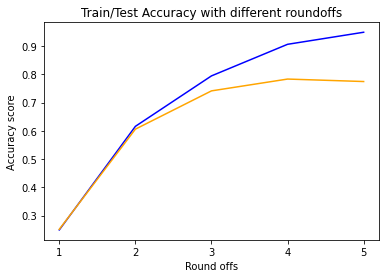

In [68]:
plt.title('Train/Test Accuracy with different roundoffs')
plt.plot(X_axis,acc_tr,color='b',label ='train')
plt.plot(X_axis,acc_ts,color='orange',label='test')
plt.xlabel('Round offs')
plt.ylabel('Accuracy score')
plt.xticks(range(len(round_place)),round_place)
plt.show()

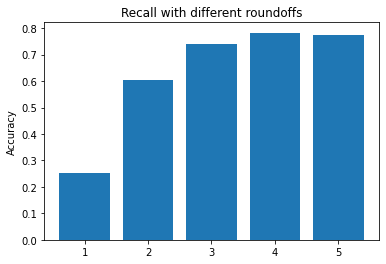

In [69]:
plt.bar(round_place,recall)
plt.title('Recall with different roundoffs')
plt.ylabel('Accuracy')
plt.show()